In [1]:
# Install a pip package in the current Jupyter kernel
import sys
import os
sys.path.append('../')
sys.path.append('../wdtools')
sys.path.append('../WD_models')
sys.path.append('../corv/src')

### General
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import astropy
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join

from tqdm import tqdm
import pandas as pd
from scipy.optimize import curve_fit
import scipy.stats as stats

### Tools
import wdtools
import WD_models
import data_selector as ds
import corv
import WD_models
from bisect import bisect_left
import lmfit
import glob

from astroquery.sdss import SDSS
from astroquery.gaia import Gaia

#corv.sdss.make_catalogs()

2022-07-14 16:34:48.400527: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-14 16:34:48.400606: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Please install galpy if you want to use the gaia module. otherwise, ignore this.
using local paths
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


In [2]:
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
speed_light = 299792458 #m/s
radius_sun = 6.957e8
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16

In [3]:
from __future__ import print_function
from astropy.coordinates import SkyCoord
import astropy.units as u
from dustmaps.bayestar import BayestarQuery

coords = SkyCoord('12h30m25.3s', '15d15m58.1s', distance = 200 * u.kpc, frame='icrs')
bsq = BayestarQuery()
ebv = bsq.query(coords)

coords = SkyCoord('12h30m25.3s', '15d15m58.1s', distance = 200 * u.kpc, frame='icrs')
print('E(B-V) = {:.3f} mag'.format(ebv))
#print(ebv)

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 33.400 s
  pix_info:   1.113 s
   samples:  17.842 s
      best:   7.497 s
       nan:   0.714 s
      sort:   6.012 s
       idx:   0.223 s
E(B-V) = 0.070 mag


In [4]:
catalog = Table.read('data/02_wd_rvs.fits')

(PAPER TO UPDATE THIS LATER)[https://iopscience.iop.org/article/10.1088/0004-637X/737/2/103#apj398709t6]

In [5]:
coords = [SkyCoord(frame="galactic", l=catalog['wd_l'][i]*u.deg, b=catalog['wd_b'][i]*u.deg, distance = (1000/catalog['wd_parallax'][i]) * u.kpc) for i in range(len(catalog))]
catalog['wd_coords'] = coords

In [6]:
catalog['E(B-V)'] = [bsq.query(catalog['wd_coords'][i]) for i in range(len(catalog))]

In [7]:
print(catalog['wd_source_id'])

    wd_source_id   
-------------------
 754878504143019136
 739253825436690432
 608113531698574592
 611167150367477888
 653782155180343040
2500203890109764608
2498756859793039232
 667328516391473920
 662468090881350016
 626494956638789248
 635639045092641280
                ...
1629777807787862784
 863565851319491840
 861577625059010176
 593918802224747776
 599615711270729984
2465208938963348224
 908364559240386944
 908667985793707264
 921840203814980608
 931304937345481344
1449461306742292608
Length = 93 rows


In [8]:
ADQL_CODE1 = "SELECT \
        sdss.original_ext_source_id as bestobjid,\
        gaia_source.source_id\
        FROM gaiaedr3.gaia_source \
        JOIN gaiaedr3.sdssdr13_best_neighbour as sdss\
        ON gaia_source.source_id = sdss.source_id      \
        WHERE gaia_source.source_id IN {}\
    ".format(tuple(catalog['wd_source_id']))

job1 = Gaia.launch_job(ADQL_CODE1,dump_to_file=False)
d1 = job1.get_results()

In [9]:
print(d1)

     bestobjid           source_id     
------------------- -------------------
1237678601317843275   78630783787018624
1237678584112349208  290678477446232960
1237680479271584161  361278458368372992
1237658492800663588  587767202170593536
1237671260664955017  593918802224747776
1237671123220365549  599615711270729984
1237670965918892088  608113531698574592
1237667538001068086  611167150367477888
1237667782819840005  626494956638789248
1237667429019418713  635639045092641280
1237667254002122820  642837135401004672
                ...                 ...
1237651539250250023 1682270490058754816
1237656495635169521 1766826194114406656
1237666244670458316 1804015873552680576
1237680332171903802 1884923638542537984
1237680500748976398 1902773453904187776
1237663268798267723 2293086475309483904
1237652629101412360 2424880574738721408
1237652901296144412 2465208938963348224
1237663784214790322 2498756859793039232
1237657070090321961 2500203890109764608
1237666407379173438 2509739915804015232


In [10]:
drops = []
bestobjid1 = []

for i in tqdm (range(len(catalog))):
    notfound = False
    a = np.where(d1['source_id'] == catalog['wd_source_id'][i])
    
    try:
        j = a[0][0]
    except:
        notfound = True
        
    if not notfound: 
        try:
            bestobjid1.append(d1['bestobjid'][j])
        except:
            notfound = True
    if notfound:
        drops.append(i)    
        
catalog.remove_rows(drops)
catalog['wd_bestobjid'] = bestobjid1

100%|██████████████████████████████████████████████████████████████████████████| 93/93 [00:00<00:00, 154.85it/s]


In [11]:
print(catalog['wd_bestobjid'])

    wd_bestobjid   
-------------------
1237661136887349316
1237667255077175502
1237670965918892088
1237667538001068086
1237667210503783269
1237657070090321961
1237663784214790322
1237664835385688318
1237667108500603237
1237667782819840005
1237667429019418713
                ...
1237671941412946020
1237655370358915142
1237653617472176153
1237671260664955017
1237671123220365549
1237652901296144412
1237657595150729272
1237654652025242137
1237654391104143521
1237651191892476035
1237667324336930835
Length = 93 rows


In [12]:
SDSS_QUERY = """select ObjID, psfMag_u, psfMagErr_u, psfMag_g, psfMagErr_g, psfMag_r, psfMagErr_r, psfMag_i, psfMagErr_i, psfMag_z, psfMagErr_z, clean, insideMask
    from dbo.PhotoObjAll
    where ObjID in {}""".format(tuple(catalog['wd_bestobjid']))

phot = SDSS.query_sql(SDSS_QUERY)

In [13]:
drops = []
Su = []
Sg = []
Sr = []
Si = []
Sz = []

fu = []
fg = []
fr = []
fi = []
fz = []

e_Su = []
e_Sg = []
e_Sr = []
e_Si = []
e_Sz = []

clean = []
inmask = []

for i in tqdm (range(len(catalog))):
    notfound = False
    a = np.where(phot['ObjID'] == catalog['wd_bestobjid'][i])
    
    try:
        j = a[0][0]
    except:
        notfound = True
        
    if not notfound: 
        Su.append(phot['psfMag_u'][j])
        Sg.append(phot['psfMag_g'][j])
        Sr.append(phot['psfMag_r'][j])
        Si.append(phot['psfMag_i'][j])
        Sz.append(phot['psfMag_z'][j])
        
        e_Su.append(phot['psfMagErr_u'][j])
        e_Sg.append(phot['psfMagErr_g'][j])
        e_Sr.append(phot['psfMagErr_r'][j])
        e_Si.append(phot['psfMagErr_i'][j])
        e_Sz.append(phot['psfMagErr_z'][j])
        
        clean.append(phot['clean'][j])
        inmask.append(phot['insideMask'][j])
    else:
        drops.append(i)    
        
catalog.remove_rows(drops)
catalog['u'] = Su# + 5 * np.log10(catalog['wd_parallax'] / 100)
catalog['g'] = Sg# + 5 * np.log10(catalog['wd_parallax'] / 100)
catalog['r'] = Sr# + 5 * np.log10(catalog['wd_parallax'] / 100)
catalog['i'] = Si# + 5 * np.log10(catalog['wd_parallax'] / 100)
catalog['z'] = Sz# + 5 * np.log10(catalog['wd_parallax'] / 100)

catalog['err_u'] = e_Su
catalog['err_g'] = e_Sg
catalog['err_r'] = e_Sr
catalog['err_i'] = e_Si
catalog['err_z'] = e_Sz

catalog['clean'] = clean
catalog['insideMask'] = inmask
#catalog.reset_index(inplace=True, drop=True)

100%|████████████████████████████████████████████████████████████████████████| 93/93 [00:00<00:00, 17757.10it/s]


In [14]:
catalog['A_u'] = np.repeat(np.nan, len(catalog))
catalog['A_g'] = np.repeat(np.nan, len(catalog))
catalog['A_r'] = np.repeat(np.nan, len(catalog))
catalog['A_i'] = np.repeat(np.nan, len(catalog))
catalog['A_z'] = np.repeat(np.nan, len(catalog))

for obj in tqdm(catalog):
    obj['A_u'] = obj['E(B-V)'] * 3.518
    obj['A_g'] = obj['E(B-V)'] * 2.617
    obj['A_r'] = obj['E(B-V)'] * 1.971
    obj['A_i'] = obj['E(B-V)'] * 1.549
    obj['A_z'] = obj['E(B-V)'] * 1.263
    
catalog['dered_u'] = catalog['u'] - catalog['A_u']
catalog['dered_g'] = catalog['g'] - catalog['A_g']
catalog['dered_r'] = catalog['r'] - catalog['A_r']
catalog['dered_i'] = catalog['i'] - catalog['A_i']
catalog['dered_z'] = catalog['z'] - catalog['A_z']

catalog['r_est'] = 1000 / catalog['ms_parallax']

100%|████████████████████████████████████████████████████████████████████████| 93/93 [00:00<00:00, 23337.94it/s]


In [15]:
font_model = WD_models.load_model('f', 'f', 'f', 'H', HR_bands = ['Su-Sg', 'Su'])

g_acc = (10**font_model['logg'])/100
rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
logg_teff_to_rsun = WD_models.interp_xy_z_func(x = font_model['logg'], y = 10**font_model['logteff'],
                                            z = rsun, interp_type = 'linear')

fitsed = WD_models.FitSED(to_flux = False, atm_type = 'H', bands = ['Su', 'Sg', 'Sr', 'Si', 'Sz'])

initialized with atm_type = H and bands = ['Su', 'Sg', 'Sr', 'Si', 'Sz']


In [16]:
def mag_to_flux(mag):
    return 10 ** ((mag + 48.6)/ -2.5) 
    
def get_model_flux(params):
    
    teff, logg, radius, distance = params['teff'], params['logg'], params['radius'], params['distance']
    
    model_mag = fitsed.model_sed(teff, logg, plx = 100)
    model_flux = mag_to_flux(model_mag)
    
    rsun = logg_teff_to_rsun(logg, teff)
    corr_radius = rsun * radius_sun
    corr_distance = 10 * pc_to_m
    
    corr_model_flux = model_flux / (4 * np.pi * (corr_radius / corr_distance)**2)
    
    radius = radius * radius_sun # Rsun to meter
    distance = distance * pc_to_m # Parsec to meter
     
    flux = corr_model_flux * ( 4 * np.pi * (radius / distance)**2 )
    
    return flux
    

def residual(params, obs_flux = None, e_obs_flux = None):
    model_flux = get_model_flux(params)

    chisquare = ((model_flux - obs_flux) / e_obs_flux)**2
    #chisquare[np.isnan(chisquare)] = 1e8
    return chisquare

In [17]:
def get_parameters(obs_mag, e_obs_mag, floor_error = 0.02, make_plot = False, vary_logg = False, p0 = [10000, 8, 0.01, 100]):      
    obs_flux = mag_to_flux(obs_mag)
    #obs_flux = obs_mag
    
    e_obs_mag = np.sqrt(e_obs_mag**2 + floor_error**2)
    e_obs_flux = e_obs_mag * obs_flux
    
    params = lmfit.Parameters()

    params.add('teff', value = p0[0], min = 3500, max = 55000, vary = True)
    params.add('logg', value = p0[1], min=7.5, max=9, vary=vary_logg)
    params.add('radius', value = p0[2], min = 0.0001, max = 0.05, vary = True)
    params.add('distance', value = p0[3], min = 1, max = 2000, vary = False)
        
    #result = lmfit.minimize(residual, params, kws = dict(obs_flux = obs_flux, e_obs_flux = e_obs_flux), method = 'emcee', steps = 5000, burn = 500, thin = 20, is_weighted = False, progress = False)
    result = lmfit.minimize(residual, params, kws = dict(obs_flux = obs_flux, e_obs_flux = e_obs_flux), method = 'leastsq')
    
    if make_plot:
        bands = ['u', 'g', 'r', 'i', 'z']
        
        plt.figure(figsize = (8,7))
        plt.errorbar(bands, obs_flux, yerr = e_obs_flux, linestyle = 'none', marker = 'None', color = 'k',
                    capsize = 5, label = 'Observed SED')
        plt.plot(bands, get_model_flux(result.params), 'bo', markersize = 10, label = 'Model SED')
        plt.xlabel('Band')
        plt.ylabel('Apparent Flux)')
        #plt.gca().invert_yaxis()
        plt.legend()    
    
    return result

4.5980863326611507e-29


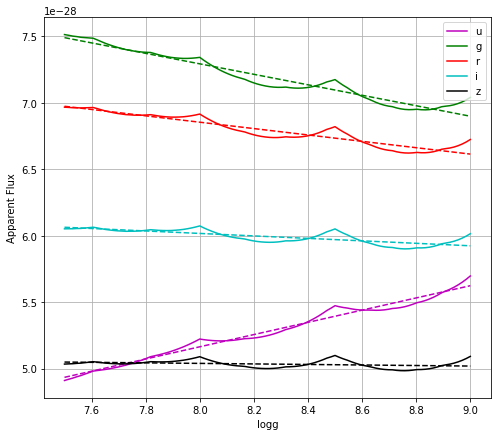

In [18]:
obs_mag = np.array([catalog['dered_u'][0] - 0.040, catalog['dered_g'][0], catalog['dered_r'][0], catalog['dered_i'][0] + 0.015, catalog['dered_z'][0] + 0.030])
e_obs_mag = np.array([catalog['err_u'][0], catalog['err_g'][0], catalog['err_r'][0], catalog['err_i'][0], catalog['err_z'][0]])

def linear(x, A, B):
    return A*x+B




ref_params = lmfit.Parameters()
ref_params.add('teff', value = 10000)
ref_params.add('logg', value = 8)
ref_params.add('radius', value = 0.01)
ref_params.add('distance', value = 200)

ref_flux = get_model_flux(ref_params)





n_logg = 100
logg_grid = np.linspace(7.5, 9, num = n_logg)

teff = 10000 #K

flux_values = []
fitted_flux_values = []

for logg in logg_grid:
    params = lmfit.Parameters()
    params.add('teff', value = teff)
    params.add('logg', value = logg)
    params.add('radius', value = 0.01)
    params.add('distance', value = 200)
        
    flux_values.append(get_model_flux(params))
    
flux_values = np.array(flux_values).T
    
bands = []
band_list = ['u', 'g', 'r', 'i', 'z']
for i in range(len(logg_grid)):
    bands.append(band_list)

bands = np.array(bands).T


popt0, pcov0 = curve_fit(linear, logg_grid, flux_values[0])
popt1, pcov1 = curve_fit(linear, logg_grid, flux_values[1])
popt2, pcov2 = curve_fit(linear, logg_grid, flux_values[2])
popt3, pcov3 = curve_fit(linear, logg_grid, flux_values[3])
popt4, pcov4 = curve_fit(linear, logg_grid, flux_values[4])

print(popt0[0])
        
plt.figure(figsize = (8,7))
#for i in range(len(bands)):
    #plt.plot(bands[i], flux_values[i], 'bo', markersize = 10)
plt.plot(logg_grid, flux_values[0], label = 'u', c = 'm')
plt.plot(logg_grid, linear(logg_grid, popt0[0], popt0[1]), linestyle='dashed', c = 'm')

plt.plot(logg_grid, flux_values[1], label = 'g', c = 'g')
plt.plot(logg_grid, linear(logg_grid, popt1[0], popt1[1]), linestyle='dashed', c = 'g')

plt.plot(logg_grid, flux_values[2], label = 'r', c = 'r')
plt.plot(logg_grid, linear(logg_grid, popt2[0], popt2[1]), linestyle='dashed', c = 'r')

plt.plot(logg_grid, flux_values[3], label = 'i', c = 'c')
plt.plot(logg_grid, linear(logg_grid, popt3[0], popt3[1]), linestyle='dashed', c = 'c')

plt.plot(logg_grid, flux_values[4], label = 'z', c = 'k')
plt.plot(logg_grid, linear(logg_grid, popt4[0], popt4[1]), linestyle='dashed', c = 'k')

plt.xlabel('logg')
plt.ylabel('Apparent Flux')
plt.grid()
plt.legend(loc = 1)
plt.savefig('/home/arseneausm/Documents/arseneausm.github.io/notes/figures/variation_sdss_ugriz.jpeg')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


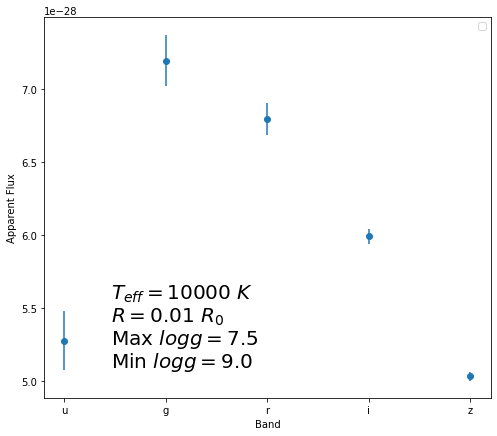

In [19]:
plt.figure(figsize = (8,7))
#for i in range(len(bands)):
    #plt.plot(bands[i], flux_values[i], 'bo', markersize = 10)
plt.errorbar(band_list, [np.mean(flux_values[i]) for i in range(len(flux_values))], yerr=[np.std(flux_values[i]) for i in range(len(flux_values))], fmt = 'o')
plt.xlabel('Band')
plt.ylabel('Apparent Flux')
plt.text(0.15, 0.26, r'$T_{eff} = 10000$ $K$', transform = plt.gca().transAxes, fontsize=20)
plt.text(0.15, 0.20, r'$R = 0.01$ $R_{0}$', transform = plt.gca().transAxes, fontsize=20)
plt.text(0.15, 0.14, r'Max $logg = 7.5$', transform = plt.gca().transAxes, fontsize=20)
plt.text(0.15, 0.08, r'Min $logg = 9.0$', transform = plt.gca().transAxes, fontsize=20)
#plt.gca().invert_yaxis()
plt.legend()   
plt.savefig('/home/arseneausm/Documents/arseneausm.github.io/notes/figures/errbar_variation_sdss_ugriz.jpeg')

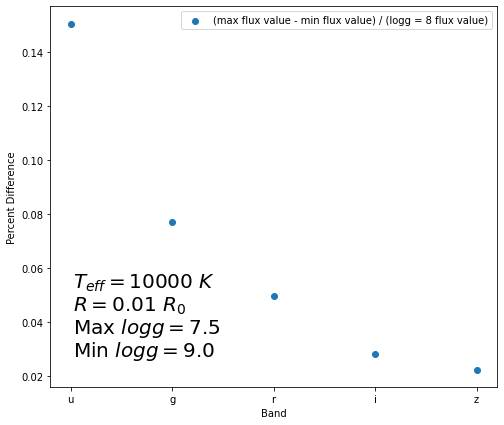

In [20]:
pct_diff = [( max(flux_values[i]) - min(flux_values[i]) ) / ref_flux[i] for i in range(len(flux_values))]

plt.figure(figsize = (8,7))
#for i in range(len(bands)):
    #plt.plot(bands[i], flux_values[i], 'bo', markersize = 10)
plt.scatter(band_list, pct_diff, label = r'(max flux value - min flux value) / (logg = 8 flux value)')
plt.xlabel('Band')
plt.ylabel('Percent Difference')
plt.text(0.05, 0.26, r'$T_{eff} = 10000$ $K$', transform = plt.gca().transAxes, fontsize=20)
plt.text(0.05, 0.20, r'$R = 0.01$ $R_{0}$', transform = plt.gca().transAxes, fontsize=20)
plt.text(0.05, 0.14, r'Max $logg = 7.5$', transform = plt.gca().transAxes, fontsize=20)
plt.text(0.05, 0.08, r'Min $logg = 9.0$', transform = plt.gca().transAxes, fontsize=20)
#plt.gca().invert_yaxis()
plt.legend()   
plt.savefig('/home/arseneausm/Documents/arseneausm.github.io/notes/figures/pctchange_sdss_urgiz.jpeg')

In [21]:
teff_10k = lmfit.Parameters()
teff_10k.add('teff', value = 10000)
teff_10k.add('logg', value = 8)
teff_10k.add('radius', value = 0.01)
teff_10k.add('distance', value = 200)

teff_3k = lmfit.Parameters()
teff_3k.add('teff', value = 3500)
teff_3k.add('logg', value = 8)
teff_3k.add('radius', value = 0.01)
teff_3k.add('distance', value = 200)

teff_50k = lmfit.Parameters()
teff_50k.add('teff', value = 50000)
teff_50k.add('logg', value = 8)
teff_50k.add('radius', value = 0.01)
teff_50k.add('distance', value = 200)

flux_3k = get_model_flux(teff_3k)
flux_10k = get_model_flux(teff_10k)
flux_50k = get_model_flux(teff_50k)

results_10k = []
results_3k = []
results_50k = []

for logg in logg_grid:
    results_3k.append(get_parameters(flux_3k, np.array([0.03,0.03,0.03,0.03,0.03]), p0 = [10000, logg, 0.01, 200]))
    results_10k.append(get_parameters(flux_10k, np.array([0.03,0.03,0.03,0.03,0.03]), p0 = [10000, logg, 0.01, 200]))
    results_50k.append(get_parameters(flux_50k, np.array([0.03,0.03,0.03,0.03,0.03]), p0 = [10000, logg, 0.01, 200]))

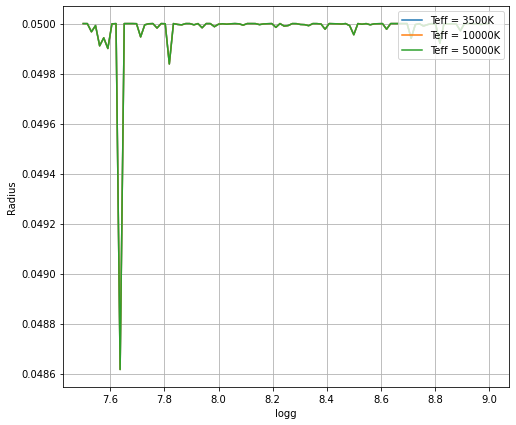

In [22]:
plt.figure(figsize = (8,7))
#for i in range(len(bands)):
    #plt.plot(bands[i], flux_values[i], 'bo', markersize = 10)
plt.plot(logg_grid, [result.params['radius'].value for result in results_3k], label = 'Teff = 3500K')
plt.plot(logg_grid, [result.params['radius'].value for result in results_10k], label = 'Teff = 10000K')
plt.plot(logg_grid, [result.params['radius'].value for result in results_50k], label = 'Teff = 50000K')

#plt.plot(logg_grid, [result.params['teff'].value for result in results], label = 'teff', c = 'r')
#plt.plot(logg_grid, linear(logg_grid, popt0[0], popt0[1]), linestyle='dashed', c = 'm')

plt.xlabel('logg')
plt.ylabel('Radius')
plt.grid()
plt.legend(loc = 1)
plt.savefig('/home/arseneausm/Documents/arseneausm.github.io/notes/figures/variation_sdss_ugriz.jpeg')

7/7 Meeting
---

Generate mock wd's at the same temp and radius but with different logg

If we are completely agnostic about the wd eq of state, then there's no relationship between radius and logg. We should see that phot is insensitive to logg to ~1%
-> if we find anything other than that, then we've got an issue and we need to find something else

If we do find sensitivity:
-> DON'T use a simple blackbody
-> If there is some sensitivity, it's because the absorbtion lines may be broader. This is kind of an atmospheric model issue if it's at the 1%
-> Do the fit at logg=7, logg=9 and add in quad

Take a 10000K wd at 0.01  rad and look at the variations on account of logg

If we want to use Sihao's code, we want to understand what is being assumed and what is not being assumed



In [23]:
results = []
results7 = []
results9 = []
e_results = []

logg_vary = []

for i in range(len(catalog)):
    obs_mag = np.array([catalog['u'][i] - 0.040, catalog['g'][i], catalog['r'][i], catalog['i'][i] + 0.015, catalog['z'][i] + 0.030])
    e_obs_mag = np.array([catalog['err_u'][i], catalog['err_g'][i], catalog['err_r'][i], catalog['err_i'][i], catalog['err_z'][i]])
    
    logg7 = get_parameters(obs_mag, e_obs_mag, vary_logg=False, p0 = [10000, 7, 0.003, catalog['r_est'][i]] )
    logg8 = get_parameters(obs_mag, e_obs_mag, vary_logg=False, p0 = [10000, 8, 0.003, catalog['r_est'][i]] )
    logg9 = get_parameters(obs_mag, e_obs_mag, vary_logg=False, p0 = [10000, 9, 0.003, catalog['r_est'][i]] )
    
    results.append(logg8)
    results7.append(logg7)
    results9.append(logg9)
    logg_vary.append(get_parameters(obs_mag, e_obs_mag, vary_logg = True, p0 = [10000, 8, 0.01, catalog['r_est'][i]]))

In [24]:
vary_catalog = catalog.copy()

catalog['radius'] = [result.params['radius'].value for result in results]
catalog['teff'] = [result.params['teff'].value for result in results]
catalog['e_teff'] = [result.params['teff'].stderr for result in results]
catalog['redchi'] = [result.redchi for result in results]
catalog['e_radius'] = [np.sqrt(results[i].params['radius'].stderr**2 + np.abs(results7[i].params['radius'].value - results9[i].params['radius'].value)**2 ) for i in range(len(results))]
catalog['error_from_model'] = [np.abs(results7[i].params['radius'].value - results9[i].params['radius'].value) for i in range(len(results))]

vary_catalog['radius'] = [result.params['radius'].value for result in logg_vary]
vary_catalog['teff'] = [result.params['teff'].value for result in logg_vary]
vary_catalog['e_teff'] = [result.params['teff'].stderr for result in logg_vary]
vary_catalog['redchi'] = [result.redchi for result in logg_vary]
vary_catalog['e_radius'] = [result.params['radius'].stderr for result in logg_vary]

In [25]:
model = WD_models.load_model('f', 'f', 'f', 'H')
font_model = model

def rv_from_radius(radarray, teffarray, lowmass = 'f', midmass = 'f', highmass = 'f'):
    
    if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
        font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')
    else:
        font_model = model

    #     font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')


    g_acc = (10**font_model['logg'])/100
    rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    
    rsun_teff_to_m = WD_models.interp_xy_z_func(x = rsun, y = 10**font_model['logteff'],\
                                                z = font_model['mass_array'], interp_type = 'linear')
    
    mass = rsun_teff_to_m(radarray, teffarray) * mass_sun
    radius = radarray * radius_sun
    rv = newton_G * mass / (speed_light * radius)

    return rv*1e-3

<>:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_4338/2006706867.py:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
/tmp/ipykernel_4338/2006706867.py:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
/tmp/ipykernel_4338/2006706867.py:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':


In [26]:
fontaine_model = WD_models.load_model('f', 'f', 'f', 'H')

        radius               e_radius             g_redshift         eg_redshift            redchi       
--------------------- ---------------------- ------------------- ------------------- --------------------
 0.012950660832499314  0.0005047892968963372  -55.61689256171803 0.24122055037117004   1.2661882992948938
 0.012429334263345837  0.0008935987905542425  -2494.128631591797  0.6708291636238098  0.05961555287620767
 0.002235104156045171  0.0033355722326198814 -2547.6644859313965   1.933296965194702   4.7442233309579676
 0.013965783921191036  0.0001279853371619819  23.497598441964783   0.483221636844635  0.02833653371663732
 0.019822621810106116  0.0005006400425177218  -80.12885344607912   7.966465787479516  0.01193534348877085
  0.01164752932148287 0.00031473827255964104   52.64977012201098  1.7917777763137817  0.01722832049456932
 0.013177095097756832  0.0011042388252338075   4.026313862144889  1.1410660014877319   2.2542420894614312
 0.009024804098372311  0.0016525505925199515  

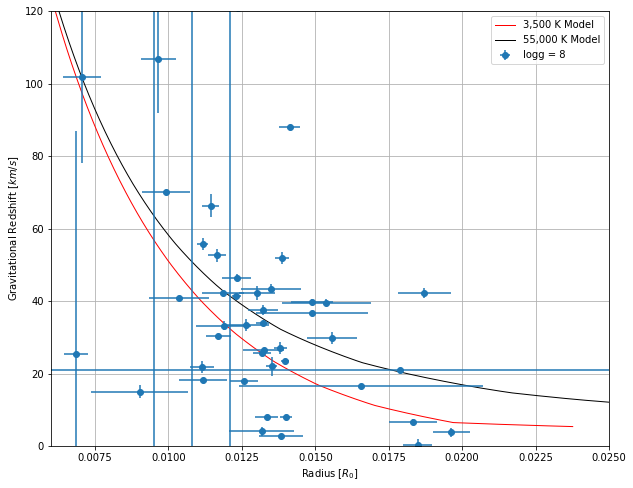

In [27]:
#tcatalog = catalog
raw_catalog = catalog

#catalog = tcatalog
#catalog = catalog[catalog['redchi'] < 2.5]
#catalog = catalog[catalog['wd_parallax_over_error'] > 10]
#catalog = catalog[catalog['e_radius'] != None]
#catalog = catalog[catalog['e_radius'] < 0.01]

vary_catalog = vary_catalog[vary_catalog['redchi'] < 2.5]
vary_catalog = vary_catalog[vary_catalog['wd_parallax_over_error'] > 10]
vary_catalog = vary_catalog[vary_catalog['e_radius'] != None]
vary_catalog = vary_catalog[vary_catalog['e_radius'] < 0.01]

print(catalog[['radius', 'e_radius', 'g_redshift', 'eg_redshift', 'redchi']])

plt.figure(figsize=(10,8))

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

plt.errorbar(catalog['radius'], catalog['g_redshift'], xerr = catalog['e_radius'], yerr=catalog['eg_redshift'], fmt='o', label = 'logg = 8')

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.xlim(0.006, 0.025)
plt.ylim(0, 120)
plt.legend()
plt.savefig('plots/photometry/gredshift_vs_radius.jpg')

Text(0, 0.5, '$T_{eff}$')

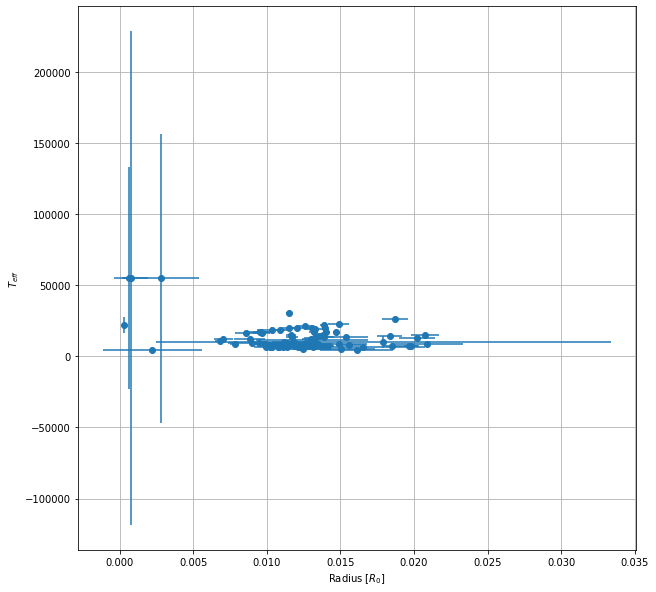

In [28]:
plt.figure(figsize=(10,10))

plt.errorbar(catalog['radius'], catalog['teff'], xerr=catalog['e_radius'], yerr=catalog['e_teff'], fmt='o')
plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'$T_{eff}$')

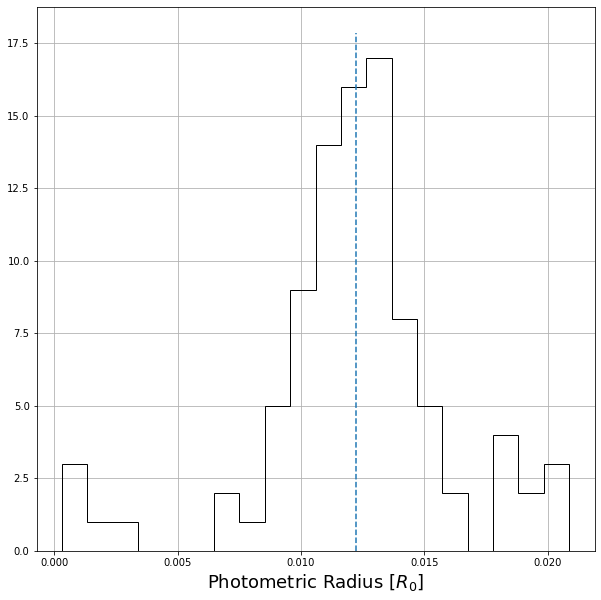

In [29]:
plt.figure(figsize=(10,10))
plt.grid()
plt.hist(catalog['radius'], bins = 20, histtype='step', color='black')
ymin, ymax = plt.ylim()
plt.vlines(np.mean(catalog['radius']), ymin, ymax, linestyles='dashed')
plt.xlabel(r'Photometric Radius $[R_{0}]$', fontsize=18)
plt.savefig('plots/photometry/radius.png')

453.007437139437


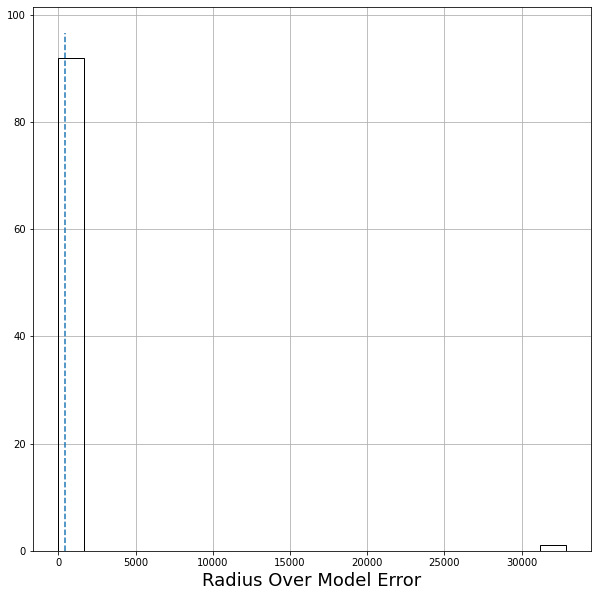

In [30]:
catalog['radius_over_error'] = catalog['radius'] / catalog['e_radius']
print(np.mean(catalog['radius'] / catalog['error_from_model']))

plt.figure(figsize=(10,10))
plt.grid()
plt.hist(catalog['radius'] / catalog['error_from_model'], bins = 20, histtype='step', color='black')
ymin, ymax = plt.ylim()
plt.vlines(np.mean(catalog['radius'] / catalog['error_from_model']), ymin, ymax, linestyles='dashed')
plt.xlabel(r'Radius Over Model Error', fontsize=18)
plt.savefig('plots/photometry/model_error.png')

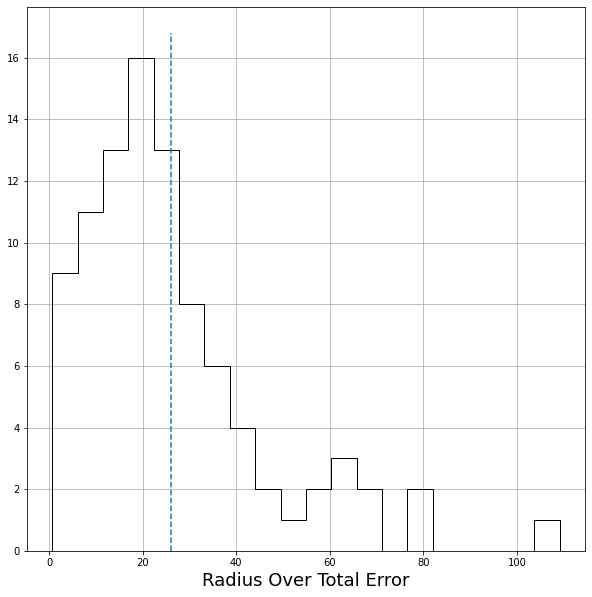

In [31]:
plt.figure(figsize=(10,10))
plt.grid()
plt.hist(catalog['radius_over_error'], bins = 20, histtype='step', color='black')
ymin, ymax = plt.ylim()
plt.vlines(np.mean(catalog['radius_over_error']), ymin, ymax, linestyles='dashed')
plt.xlabel(r'Radius Over Total Error', fontsize=18)
plt.savefig('plots/photometry/radius_over_error.png')

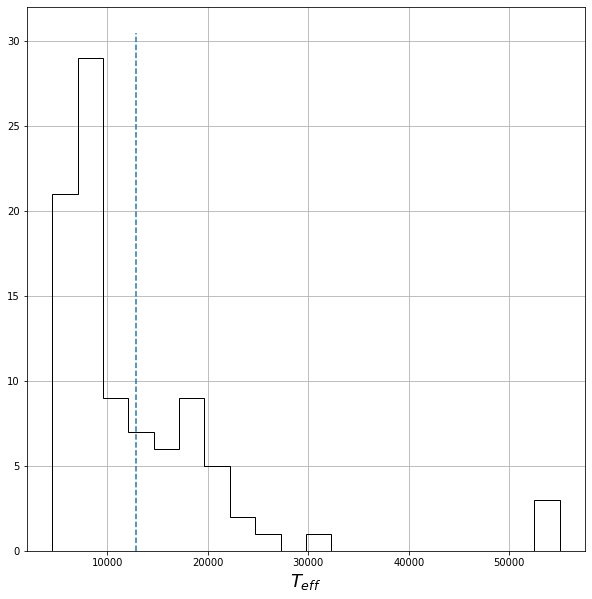

In [32]:
plt.figure(figsize=(10,10))
plt.grid()
plt.hist(catalog['teff'], bins = 20, histtype='step', color='black')
ymin, ymax = plt.ylim()
plt.vlines(np.mean(catalog['teff']), ymin, ymax, linestyles='dashed')
plt.xlabel(r'$ T_{eff}$', fontsize=18)
plt.savefig('plots/photometry/teff.png')

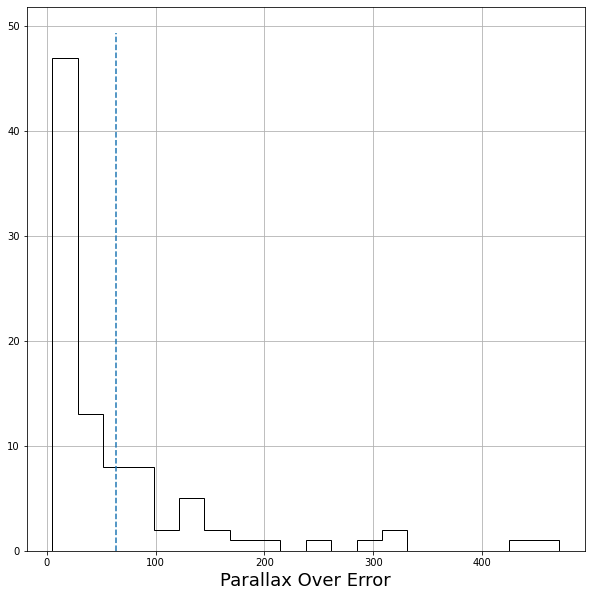

In [33]:
plt.figure(figsize=(10,10))
plt.grid()
plt.hist(catalog['wd_parallax_over_error'], bins = 20, histtype='step', color='black')
ymin, ymax = plt.ylim()
plt.vlines(np.mean(catalog['wd_parallax_over_error']), ymin, ymax, linestyles='dashed')
plt.xlabel(r'Parallax Over Error', fontsize=18)
plt.savefig('plots/photometry/parallax_over_error.png')

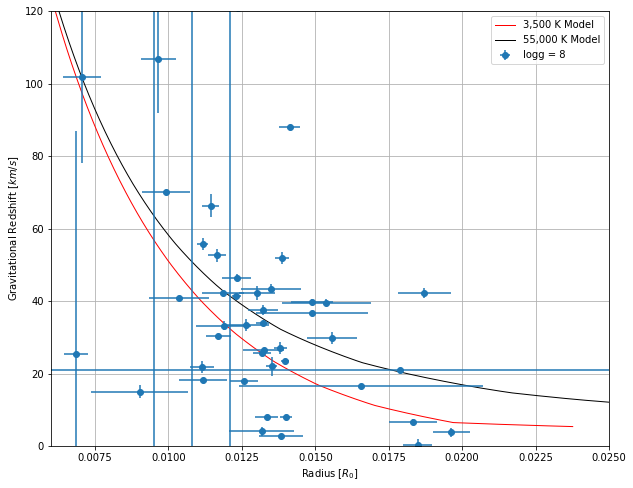

In [34]:
#catalog = catalog[catalog['radius_over_error'] > 5]

plt.figure(figsize=(10,8))

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

plt.errorbar(catalog['radius'], catalog['g_redshift'], xerr = catalog['e_radius'], yerr=catalog['eg_redshift'], fmt='o', label = 'logg = 8')

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.xlim(0.006, 0.025)
plt.ylim(0, 120)
plt.legend()
plt.savefig('plots/photometry/cleaned_gredshift_vs_radius.jpg')

In [35]:
catalog.write('data/02_photometry.fits', overwrite=True)
raw_catalog.write('data/02_photometry_raw.fits', overwrite=True)